# Project Milestone 2
## Project title: "Firearms debate in the USA and its relation to mass shootings"

Students: Thomas **Defauw**, Margaux **L'Eplattenier**, Clément **Rio**, Zewei **Xu**<br>
Due date: November 12, 2021

In [1]:
#Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tld import get_tld
import json
import bz2
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Disable some pandas warnings we don't want in the notebook
pd.options.mode.chained_assignment = None

## 0 - Accessing the data from Quotebank and the speaker attributes dataset

The Quotebank dataset is very large in size and it is not feasible to treat it using only RAM memory. In order to circumvent this problem, we chose to **filter out all the quotes that were not linked to our study**. 

For this second milestone, we chose a simple algorithm that consisted in selecting only the quotes that contained at least one of the following keywords: 'gun', 'shooting', 'firearm'. The selected quotes were written to a new file: 'quotes-cropped.json', which was much more reasonnable in size: around 550 Mo. This was done on a **Google Colab** so that we could access the Quotebank dataset from Drive.

We know this is not a perfect filter, but it should get the job done for these initial findings. For milestone 3, we plan on using a **supervised learning** algorithm in order to identify quotes that speak of shootings/guns with higher precision.

In [2]:
#def get_domain(url):
#    res = get_tld(url, as_object=True)
#    return res.domain
#
#new_src = pd.read_csv('data/news.txt', delimiter="\t", header=None, encoding = "ISO-8859-1")
#new_src.columns=['id','unknown','date','country','media','website','title']
#new_src['domain']=new_src.apply(lambda x : get_domain(x['website']),axis=1)
#new_src.drop_duplicates(inplace=True, subset=['domain'], keep='first')
#new_src.head()

In [3]:
#path_to_out = 'data/quotes-cropped-with-country.json.bz2'
#with bz2.open("data/quotes-cropped.json.bz2", 'rb') as s_file:
#    with bz2.open(path_to_out, 'wb') as d_file:
#        for instance in s_file:
#                instance = json.loads(instance) # loading a sample
#                urls = instance['urls'] # extracting list of links 
#                instance['country']=np.nan
#                for url in urls:
#                    domain=get_domain(url)
#                    if len(new_src[new_src['domain']==domain])>=1:
#                        instance['country']=new_src[new_src['domain']==domain]['country'].item()
#                        break
#                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [4]:
## New dataframe with the data ('quotes-cropped.jspon')
#with bz2.open("data/quotes-cropped-with-country.json.bz2", 'rb') as s_file: 
#    df_original = pd.read_json(s_file, lines=True)
#
#df_original.head()

In [5]:
#df_original=df_original[df_original['country']=='US']
#df_original.head()

In [6]:
# New dataframe with the data ('quotes-cropped.jspon')
df_original = pd.read_json('quotes-cropped.json', lines=True)

We have also loaded the **speaker attributes dataset** in order to extract additional information about quotations' speakers, in case we need these for statistic purpose later on.

In [7]:
# New dataframe with the speaker attributes data ('speaker_attributes.parquet')
#!pip install pandas pyarrow
speaker_attributes = pd.read_parquet('data/speaker_attributes.parquet')
speaker_attributes.sample()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3403246,None,[+1490-01-01T00:00:00Z],[Q183],[Q6581097],1390223818,None,None,[Q432386],None,None,Q110702,Bernhard Krechting,None,item,[Q165580]


In [8]:
# Extract the 'speaker' column from the Quotebank data.
#df_speaker = df_original['speaker']

# Remove rows in the 'speaker attributes' dataset which are not related to speakers in the Quotebank
#index = speaker_attributes.apply(lambda x: len(df_speaker[df_speaker==x['label']])>0 , axis=1)

# Match index
#speaker_attributes = speaker_attributes[index]
#speaker_attributes.head()

# Save the new data to a .csv file
#speaker_attributes.to_csv('data/speaker.csv')

## 1 - Initial analysis of the cropped Quotebank dataset

We will start by plotting the number of quotes containing at least one of our keywords over time (i.e. between 2015 and 2020). Even though some quotes will be irrelevant (e.g. "we were **shooting** a movie"), we assume the distribution of these irrelevant quotes to be close to uniform for the moment. For the final project, we plan to be using Machine Learning algorithms to better select the data from the Quotebank dataset (instead of the keywords), choosing only quotes who have a high probability to be relevant.

Our plot should therefore give a good first impression on how much people/the media has been speaking about gun control during these five years.

In [9]:
# Keep only the columns that we need for our initial analysis
df = df_original[['date','quotation']]

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head(n=3)

,date,quotation
65127,2015-01-01 00:07:32,When we are face a suspect holding one of thes...
77653,2015-01-01 00:08:12,I expect much of the same from Edinburgh at Mu...
97745,2015-01-01 00:13:41,Of course the negative is if you need your gun...


Now that we have sorted the dataframe by date, we can move on to the plot.

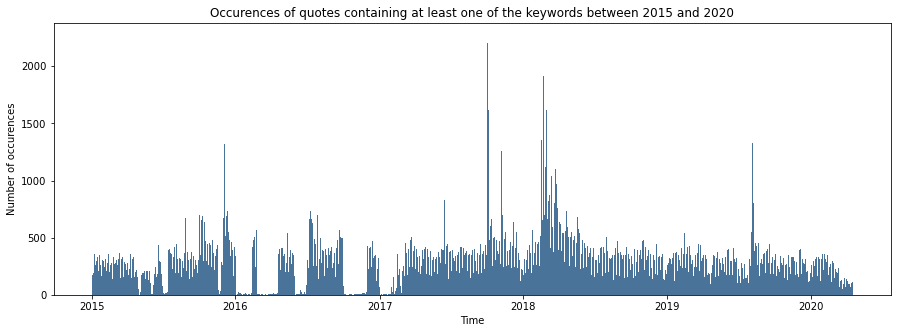

In [10]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.hist(df['date'], bins=2000, color='#4a7399')

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

This histogram gives a good idea of how much people have been speaking of guns/firearms/shootings in the last 5 years in the media. **But it has a major flaw**: each quote has the same "weight" (one quote accounts for one occurence). But some quotes occure more often then others ('numOccurences' colum in the dataframe). We should take this extra information into account if we want a better view on the data.

We will now define a new dataframe that contains the number of quotes (multiplied by their respective occurences) for each day that contain at least one of the keywords.

In [11]:
# Define a new dataframe for this specific study
df = df_original[['date','numOccurrences']]

# Remove hour from the date
df['date'] = df['date'].dt.date

# Group by date and sum number of occurences
df = df.groupby(['date']).sum()
df = df.reset_index()

# Convert data column back to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head(n=3)

,date,numOccurrences
0,2015-01-01,261
1,2015-01-02,555
2,2015-01-03,332


We now have our desired dataframe: one row is one day, and for each day we have the number of quotes (multiplied by their occurences) that contain at least a keyword.

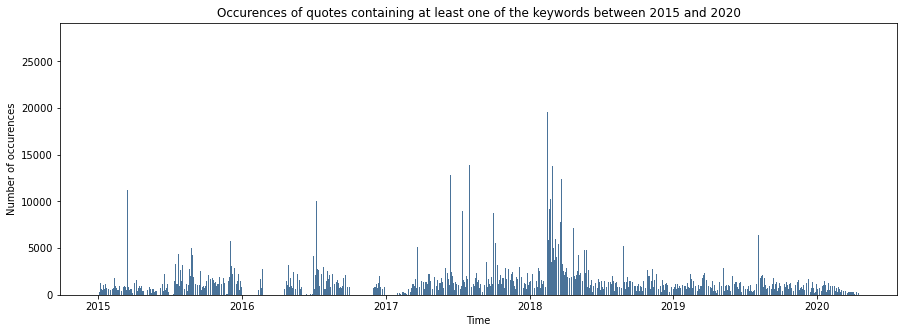

In [12]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.bar(df['date'],df['numOccurrences'],color='#4a7399')
plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

We have cleared a possible source of error out of the way. We will be using this new dataframe in the rest of the analysis. If we happen to need more information about the quotes that were said on a specific date, we can always switch back to looking for quotes on that specific date in the original dataframe (from the "cropped" Quotebank).

In [13]:
# We will use this data in comparitive plots in part 3
data1 = df[['date','numOccurrences']]

## 2 - Initial analysis of the "Mother Jone's" dataset

We have also proceeded to some initial analysis of the "Mother Jone's US Mass Shootings" dataset. Indeed, this dataset will give us some basic information about most shootings, such as: date, location, number of fatalities, number of injured, age of shooter, weapon type/legality...

In [14]:
# Reading the csv file
df = pd.read_csv('./Data/MassShootings.csv')

# Replace "-" by NaN in "age of shooter" column
df['age_of_shooter'] = df['age_of_shooter'].replace('-', np.nan).astype(float)

# Two new columns: location splitted into town and state
df[['town', 'state']] = df['location'].str.split(', ', expand = True)

# Convert date column to datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Quotebank dataset is limited to years 2015-2020. Need to use same time span:
df = df.drop(df[df['date'].dt.year < 2015].index)
df = df.drop(df[df['date'].dt.year > 2020].index)

df.dtypes

case                                        object
location                                    object
date                                datetime64[ns]
summary                                     object
fatalities                                   int64
injured                                      int64
total_victims                                int64
location.1                                  object
age_of_shooter                             float64
prior_signs_mental_health_issues            object
mental_health_details                       object
weapons_obtained_legally                    object
where_obtained                              object
weapon_type                                 object
weapon_details                              object
race                                        object
gender                                      object
sources                                     object
mental_health_sources                       object
sources_additional_age         

To give us a first glimpse at the data, we can plot the fatalities per shooting accross time, as well as the distribution of the number of fatalities per shooting.

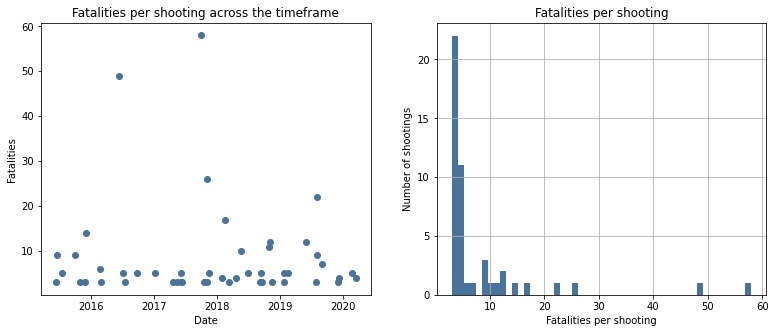

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

# Plot shootings in (time, number of fatalities) format
ax[0].scatter(df['date'], df['fatalities'], color='#4a7399')
ax[0].set_title('Fatalities per shooting across the timeframe')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Fatalities');

# Plot the distribution of the number of fatalities
ax[1] = df['fatalities'].hist(bins=50, color='#4a7399')
ax[1].set_xlabel('Fatalities per shooting')
ax[1].set_ylabel('Number of shootings')
ax[1].set_title('Fatalities per shooting');

There isn't much data, but we can say it seems to follow a power law: most of the shootings have a small number of fatalities (<10), but some large outliers are not unusual, some shootings having over 40 fatalities.

There are many paramters to explore, and one of them is **location** (as in the state) of the event:

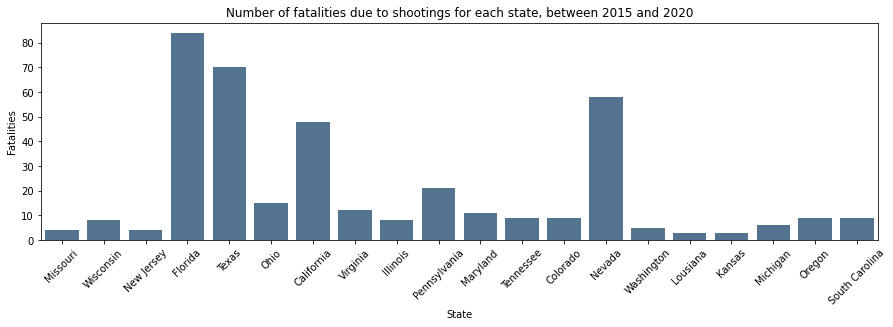

In [15]:
# Ploting the number of fatalities per state
fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.barplot(y = df['fatalities'], x = df['state'], estimator = sum, ci = None, color='#4a7399')

ax.set_xlabel("State")
ax.set_ylabel("Fatalities")
ax.set_title("Number of fatalities due to shootings for each state, between 2015 and 2020")
plt.xticks(rotation=45)
plt.show()

With the above plot, we can clearly see that **states have been very unequally affected by mass shootings**. We will try to find some relevant correlations further on, such as average salary in the state, state political position (more of a 'blue state' or a 'red state'), etc. It will also be interesting to see how these parameters influence the media outrage after the shooting.

We will now have a quick look at other interesting information we have on each event: the **type of location** (Workplace, School...), wheather or not the weapons were obtained **legally**, etc.

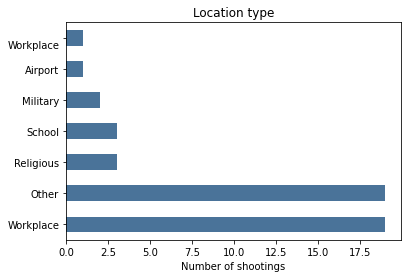

In [16]:
# Rename column location.1 to remove the dot
df.rename(columns={"location.1": "location1"}, inplace=True)
                   
df.location1.value_counts().plot(kind='barh',color='#4a7399')
plt.title('Location type')
plt.xlabel('Number of shootings')
plt.show()

Again, race of the shooter could be a possible covariate for the media covering of the shooting, and we will invesigate on this later on. 

In [17]:
# Check if the used weapons were obtained legally or not:
df.weapons_obtained_legally.value_counts().head()

Yes        25
TBD         7
-           6
No          4
Unknown     3
Name: weapons_obtained_legally, dtype: int64

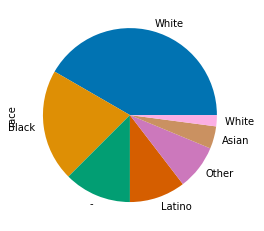

In [18]:
df.race.value_counts().plot(kind='pie',colors=sns.color_palette('colorblind'))
plt.show()

Finally, we will use this dataframe in comparitive plots in part 3.<br>Therefore we save it to a new dataframe (in case we want to overwrite "df" further on):

In [20]:
# Declares the model
mod = smf.ols(formula='fatalities ~ injured + age_of_shooter', data=df, missing = 'drop')

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             fatalities   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     31.45
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           3.84e-09
Time:                        16:48:34   Log-Likelihood:                -154.29
No. Observations:                  46   AIC:                             314.6
Df Residuals:                      43   BIC:                             320.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.0035      3.509      3.

In [21]:
data2 = df[['date','fatalities']]

## 3 - Linking the two datasets

### 3.1 - Plotting both datasets in the same timeline

We will start by plotting a single timeline graph with the number of fatalities due to shootings over time, as well as the occurence of gun-related words in the media.

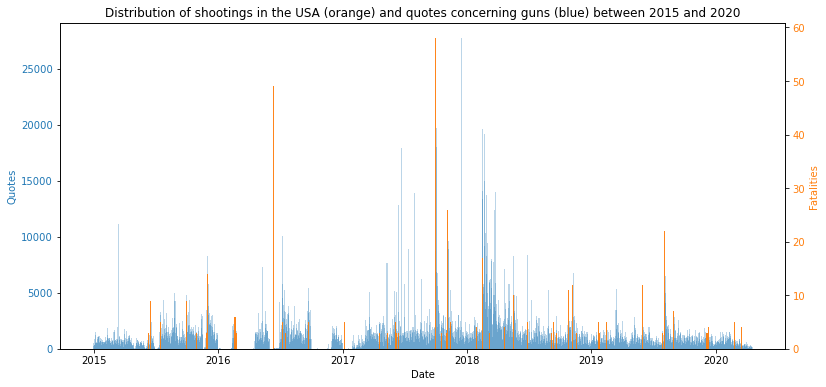

In [23]:
fig, ax1 = plt.subplots(figsize=(13,6))

# Plotting the quotes over time (blue)
color = 'tab:blue'
ax1.set_title('Distribution of shootings in the USA (orange) and quotes concerning guns (blue) between 2015 and 2020')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(data1['date'], data1['numOccurrences'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (orange)
color = 'tab:orange'
ax2.set_ylabel('Fatalities', color=color)
ax2.bar(data2['date'], data2['fatalities'], color=color, alpha=0.95, width = 3)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

We can see several interesting events in this first plot. For example, the largest peak in fatalities happens around october 2017. It is followed by the second largest peak in quotes talking about guns.

In [24]:
# Print the largest shooting (most fatalities)
data2 = data2.sort_values(by='fatalities',ascending=False)
data2 = data2.reset_index(drop=True)
print("The largest shooting was:")
print(data2.iloc[0])

# Quotes following the shooting (two days after)
data1 = data1.sort_values(by='numOccurrences',ascending=False)
print("\nThe corresponding peak in quotes discussing guns was:")
print(data1.iloc[1])

The largest shooting was:
date          2017-10-01 00:00:00
fatalities                     58
Name: 0, dtype: object

The corresponding peak in quotes discussing guns was:
date              2017-10-02 00:00:00
numOccurrences                  19722
Name: 999, dtype: object


With the above print, we see that this peak is maximal exactly two days after the shooting.

### 3.2 - Correlation between mass shootings and number of quotes

Before going into any further analysis, we need to show that there is an association between the occurences of mass shootings (in red) and the number of quotes in our subset (in blue).

In order to do this, we will test the correlation between the number of quotes in the subset and the number of days since the last shooting.

In [25]:
# Create a new column with the day of the last shooting
data1['DateLastShooting'] = np.nan

for index, row in data1.iterrows():
    row_date = row['date']
    past_shootings = data2[data2['date'] < row_date]
    last_shooting = np.max(past_shootings['date'])
    data1.at[index, 'DateLastShooting'] = last_shooting

# Convert column to date-time format
data1['DateLastShooting'] = pd.to_datetime(data1['DateLastShooting'])

# Create another column with the number of days since the last shooting 
data1['DaysSinceLastShooting'] = (data1['date'] - data1['DateLastShooting']).dt.days
data1.sample()

,date,numOccurrences,DateLastShooting,DaysSinceLastShooting
1718,2019-09-21,751,2019-08-31,21.0


In [26]:
# Drop rows containing missing values
data1_filtered = data1.dropna()

# Pearson correlation
from scipy.stats import stats
stats.pearsonr(data1_filtered['DaysSinceLastShooting'], data1_filtered['numOccurrences'])

(-0.16177454587465978, 7.993721727151127e-12)

We observe a **highly significant** (p-value << 0.05) **negative correlation** between the number of quotes on a given day and the days since the last shooting. This was the expected result: the more days since the last shooting, the rarer the quotes talking about guns and firearms.

### 3.3 - Influence of the number of fatalities on the count of quotes

We can see that the largest peak in quotes concerning guns takes place just after a shooting in early 2018:

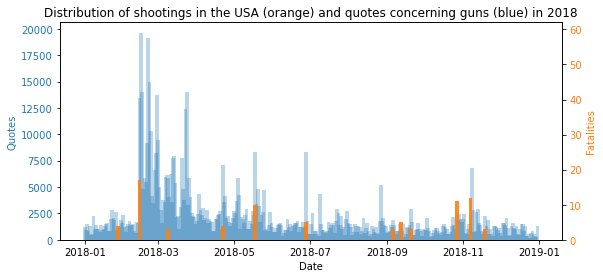

In [27]:
# We want to zoom in by looking only at 2018
data1_2018 = data1[(data1['date'].dt.year==2018)]
data2_2018 = data2[(data2['date'].dt.year==2018)]

fig, ax1 = plt.subplots(figsize=(9,4))

# Plotting the quotes over time (blue barplot)
color = 'tab:blue'
ax1.set_title('Distribution of shootings in the USA (orange) and quotes concerning guns (blue) in 2018')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(data1_2018['date'], data1_2018['numOccurrences'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (orange barplot)
color = 'tab:orange'
ax2.set_ylabel('Fatalities', color=color)
ax2.bar(data2_2018['date'], data2_2018['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,62)

plt.show()

It seams that this particular event has made much more noise then the others and over a larger period of time. The fact that it was **certainly not the shooting with the most fatalities** ("only" 17, compared to 58 for the max) shows that the number of fatalities is clearly not the only parameter that influences the media coverage of the event as well as the amplitude of the discussion on gun control afterwards.

**This makes us want to investigate further: what are the other factors that can explain these differences?** Some ideas: 
- Location of the shooting (what state, but also what type of place: e.g. at a school, workplace...)
- Wheather of not the weapon was bought legally
- Age, gender and ethnicity of the shooter and/or the victims
- The type of weapon that was used
- etc.

### 3.4 - Selecting the timeframe following each shooting
In order to analyse the media's response to each shooting, we can start by selecting only the quotes from the following N days (for the moment we chose N=10 days). We did this for the top 3 most lethal shootings and plotted the results below. These again emphasize the idea that there is much more than just the number of fatalities (the second most lethal shooting creates a minimal response compared to the others).

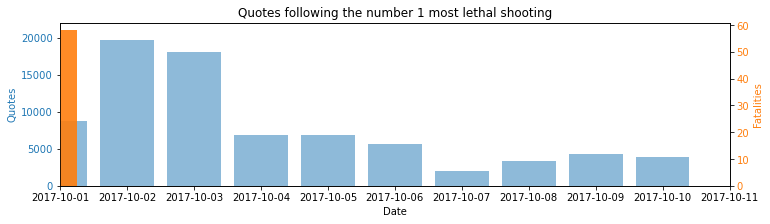

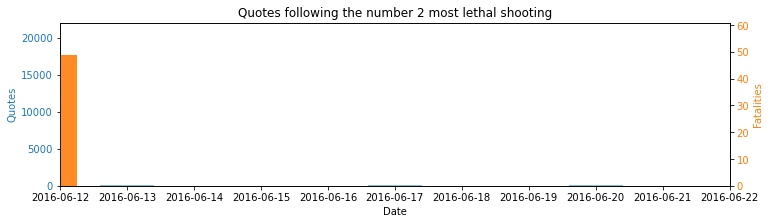

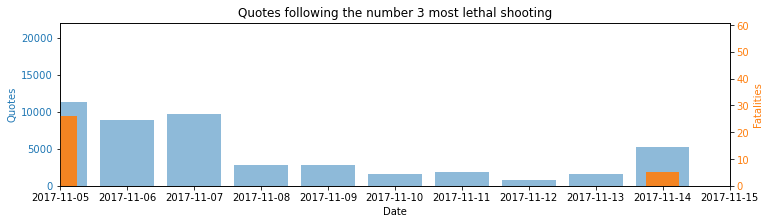

In [28]:
# We want to zoom in for the 10 days after each shooting
from datetime import timedelta

for i in range(0,3):
    
    # Get the date of the (i+1)th most lethal shooting
    shooting_date = data2.sort_values(by='fatalities',ascending=False)['date'].iloc[i]
    
    # Select only the quotes in the 10 days following the selected shooting
    shooting_after =  data1[((data1['date'] >= shooting_date))]
    shooting_after =  shooting_after[(shooting_after['date'] < shooting_date + timedelta(days=10))]

    fig, ax1 = plt.subplots(figsize=(12,3))
    
    # Plotting the quotes over time (blue barplot)
    color = 'tab:blue'
    ax1.set_title('Quotes following the number ' + str(i+1) + ' most lethal shooting')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quotes', color=color)
    ax1.bar(shooting_after['date'], shooting_after['numOccurrences'], color=color, alpha=0.5, width = 0.8)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(shooting_date,shooting_date+ timedelta(days=10))
    ax1.set_ylim(0,22000)
    
    # Same x-axis, but different y axis
    ax2 = ax1.twinx()
    
    # Plotting the fatalities due to shootings over time (orange barplot)
    color = 'tab:orange'
    ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
    ax2.bar(data2['date'], data2['fatalities'], color=color, alpha=0.9, width = 0.5)
    ax2.tick_params(axis='y', labelcolor=color)

plt.show()

### 3.5 - Goals for the future of the study

Our final goal would be to have a single value (or score) that represents the media's reaction to each event. For example, a score of 1 would be maximal reaction, and a score of 0 would be no reaction. We could then **use linear regression to find how each parameter influences the reaction score**: location, age/gender/ethnicity of shooter, gun legality... We could have this score based on the slope of the number of quotes after the shooting.

Another interesting possibility for analysis is to look at the political positionning of the speakers and/or news sources for the quotes. We could see if there is a **correlation between policial views and topic covering** (e.g. more democrat-leaning speakers would talk about the event if the weapon was legally obtained).

If there is an equilibrium between the coverage on both sides, then it is likely that the reaction of the media can be considered as important, as everyone is talking about it. This could be part of what determins the "reaction score" of an event.